In [1]:
import numpy as np
import torch
import torch.nn as nn
import time 
import logging
import torch.optim as optim
import os
from scipy.stats import multivariate_normal as normal
import torch.nn.functional as F
from torch.nn import Parameter
import matplotlib.pyplot as plt
import torchvision

In [2]:
%matplotlib inline
torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [3]:
from torchvision import transforms
from torchvision import datasets 

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

data_type=torch.float32
MOMENTUM = 0.99
EPSILON = 1e-6

Using cuda device


In [5]:
class Config(object):
    batch_size = 500
    
    totalT=2.0;
    
    n_layer=Ntime=4; 
    
    sqrt_deltaT=np.sqrt(totalT/Ntime); 

    logging_frequency = 100
    verbose = True
   
    input_chanel=1
    output_chanel_pj1=32
    output_chanel_pj2=16 
    
    unflatten_shape=output_chanel_pj2*7*7
    
def get_config(name):
    try:
        return globals()[name]
    except KeyError:
        raise KeyError("config not defined.")
cfg=get_config('Config')

In [6]:
batch_size_train=cfg.batch_size
batch_size_test=cfg.batch_size

In [7]:
train_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST('/files/', train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=cfg.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST('/files/', train=False, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=cfg.batch_size, shuffle=True)

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

## Plain vanilla CNN

In [9]:
class ProjBlock(nn.Module):
    def __init__(self,input_chanel,output_chanel):
        super(ProjBlock,self).__init__()
        self.input_chanel=input_chanel
        self.output_chanel=output_chanel
        
        self.conv1=nn.Conv2d(input_chanel,output_chanel,kernel_size=3,padding=1) 
        self.act1=nn.Tanh()
        self.pool1=nn.MaxPool2d(2)
        
      #  self.conv2=nn.Conv2d(2*output_chanel,output_chanel,kernel_size=3,padding=1) 
      #  self.act1=nn.Tanh()
      #  self.pool1=nn.MaxPool2d(2)
    
    def forward(self,x):
        out = self.pool1(self.act1(self.conv1(x)))
      #  out = self.pool2(self.act2(self.conv2(x)))
        return out

In [10]:
class BasicBlock(nn.Module):
    def __init__(self,num_chanel):
        super(BasicBlock,self).__init__()
        self.input_chanel=num_chanel
        self.output_chanel=num_chanel
        
        self.conv=nn.Conv2d(self.input_chanel,self.output_chanel,kernel_size=3,padding=1)
        self.act=nn.Tanh()
        ## there should not be any MaxPooling layer in the inbetween set
        
    def forward(self,x):
        out=self.act(self.conv(x))
        return out

In [11]:
class FullyConnected(nn.Module):
    def __init__(self,unflatten_shape): 
        super(FullyConnected,self).__init__()
        self.unflatten_shape=unflatten_shape
        self.fc1=nn.Linear(unflatten_shape,32)
        self.ac1=nn.Tanh()
        self.fc2=nn.Linear(32,10) 
        # Let's only tell the airplane from a bird
    
    def forward(self,x):
        inputx=x.view(-1, self.unflatten_shape)
        out=self.fc2(self.ac1(self.fc1(inputx)))
        return out

## Stacking up the blocks

In [12]:
loss_fn=nn.CrossEntropyLoss()

In [13]:
class ForwardModel(nn.Module):
    def __init__(self,config):
        super(ForwardModel,self).__init__()
        
        self.config=config
        self.batch_size=self.config.batch_size
        self.Ntime=self.config.Ntime
        self.sqrt_deltaT=self.config.sqrt_deltaT;
        self.n_layer=self.config.n_layer
        
        ## The structure is merely a stack-up of the convolutional blocks
        self.mList=nn.ModuleList([ProjBlock(self.config.input_chanel,self.config.output_chanel_pj1),
                                  ProjBlock(self.config.output_chanel_pj1,self.config.output_chanel_pj2),
                                  BasicBlock(self.config.output_chanel_pj2),
                                  BasicBlock(self.config.output_chanel_pj2),
                                  BasicBlock(self.config.output_chanel_pj2),
                                  BasicBlock(self.config.output_chanel_pj2),
                                  FullyConnected(self.config.unflatten_shape)                              
        ])
    
    def forward(self,data):
        data_temp=torch.clone(data)
        for block in self.mList:
            data_temp=block(data_temp)
        return data_temp

In [14]:
def train_accuracy(model,train_loader):
    total=0;
    correct=0;
    for imgs,labels in train_loader: 
        imgs, labels=imgs.to(device), labels.to(device)
        output=model(imgs)
        _, predicted = torch.max(output, dim=1)
        
        total += imgs.shape[0]
        correct += int((predicted == labels.to(device)).sum())
    return correct/total

### We now read the coefficient of the plain vanilla nn

The train accuracy after 8 epochs achieves 99.2%, and the test accuracy achieves 98.7%

In [15]:
pretrained_model='data/VanillaCNN_fashion_mnist_model.pth'

In [16]:
net=ForwardModel(cfg)
net.to(device);

In [17]:
net.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

<All keys matched successfully>

In [18]:
# The net will only evaluate samples from now
net.eval();

In [19]:
# FGSM attack code
# which also works in the batch case
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
#    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [20]:
def test(model,device, epsilon, test_loader):
    correct = 0
    total = 0
    adv_ex=[]
    for imgs, labels in test_loader:
        
        imgs, labels=imgs.to(device), labels.to(device)
        imgs.requires_grad=True
        output=model(imgs)
        loss=loss_fn(output,labels)
        _,predict_init=torch.max(output,dim=1)
   
        model.zero_grad()
   #     # Calculate gradients of model in backward pass
        loss.backward()
    
        data_grad=imgs.grad.data
        perturbed_data = fgsm_attack(imgs, epsilon, data_grad)
        
        output_final=model(perturbed_data)
        _,predict_final=torch.max(output_final,dim=1)
        
        correct += int((predict_final.to(device) == labels.to(device)).sum()) 
        total += imgs.shape[0]
        
        adv_idx=~(predict_final.to(device) == labels.to(device))
        adv_imgs=perturbed_data[adv_idx]; 
        if (len(adv_imgs)>0 ) and (len(adv_ex)<5): 
            adv_ex.append((predict_init[adv_idx][0].item(),predict_final[adv_idx][0].item(),adv_imgs[0].squeeze().detach().cpu().numpy() ))
                
    return  correct/total , adv_ex

## Test

In [23]:
epsilons = [0, .05,.1,.15,0.2,0.3,0.4,0.5]

In [24]:
accuracies = []
examples = []
adv_examples=[]

# Run test for each epsilon
for eps in epsilons:
    acc, adv_ex= test(net, device, eps, test_loader)
    print(acc)
    accuracies.append(acc)
    adv_examples.append(adv_ex)

0.9096
0.567
0.4289
0.3432
0.2832
0.211
0.1685
0.1437


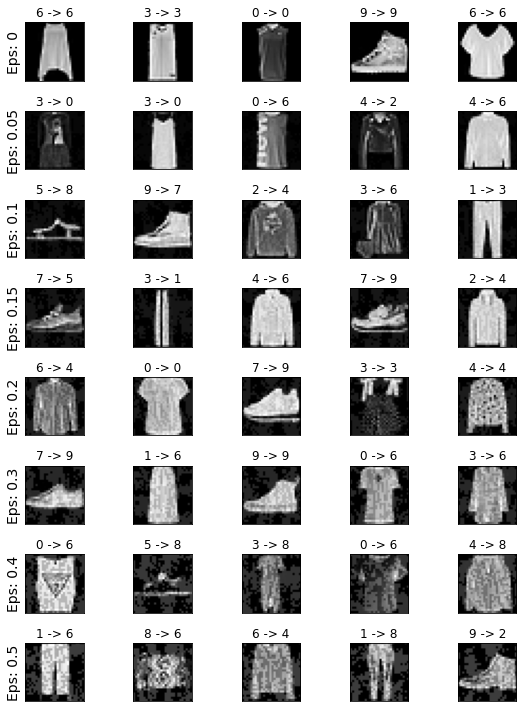

In [25]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(adv_examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(adv_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = adv_examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()